# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [46]:
# # ! python -m pip install --upgrade pip
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # ! pip install --upgrade --force-reinstall torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install setuptools
# ! pip install --upgrade --force-reinstall transformers==4.36.0
# ! pip install transformers
# ! pip install tensorflow
# ! pip install tf-keras
# ! pip show transformers
! pip show transformers


Name: transformers
Version: 4.36.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: e:\repos_kioxia\win\mgr\.venv\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [1]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.3.0+cu118
True
CUDA version: 11.8


C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_19224\2822029800.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [48]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("arpanghoshal/EmoRoBERTa")
# model = AutoModelForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")
model = AutoModelForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa", from_tf=True)

Loading a TensorFlow model in PyTorch, requires both PyTorch and TensorFlow to be installed. Please see https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.


ImportError: cannot import name 'TFGenerationMixin' from 'transformers.generation' (e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\generation\__init__.py)

In [15]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa')

emotion_labels = emotion("Thanks for using it.")
print(emotion_labels)

OSError: Can't load tokenizer for 'arpanghoshal/EmoRoBERTa'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'arpanghoshal/EmoRoBERTa' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [4]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001987FE0D260>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

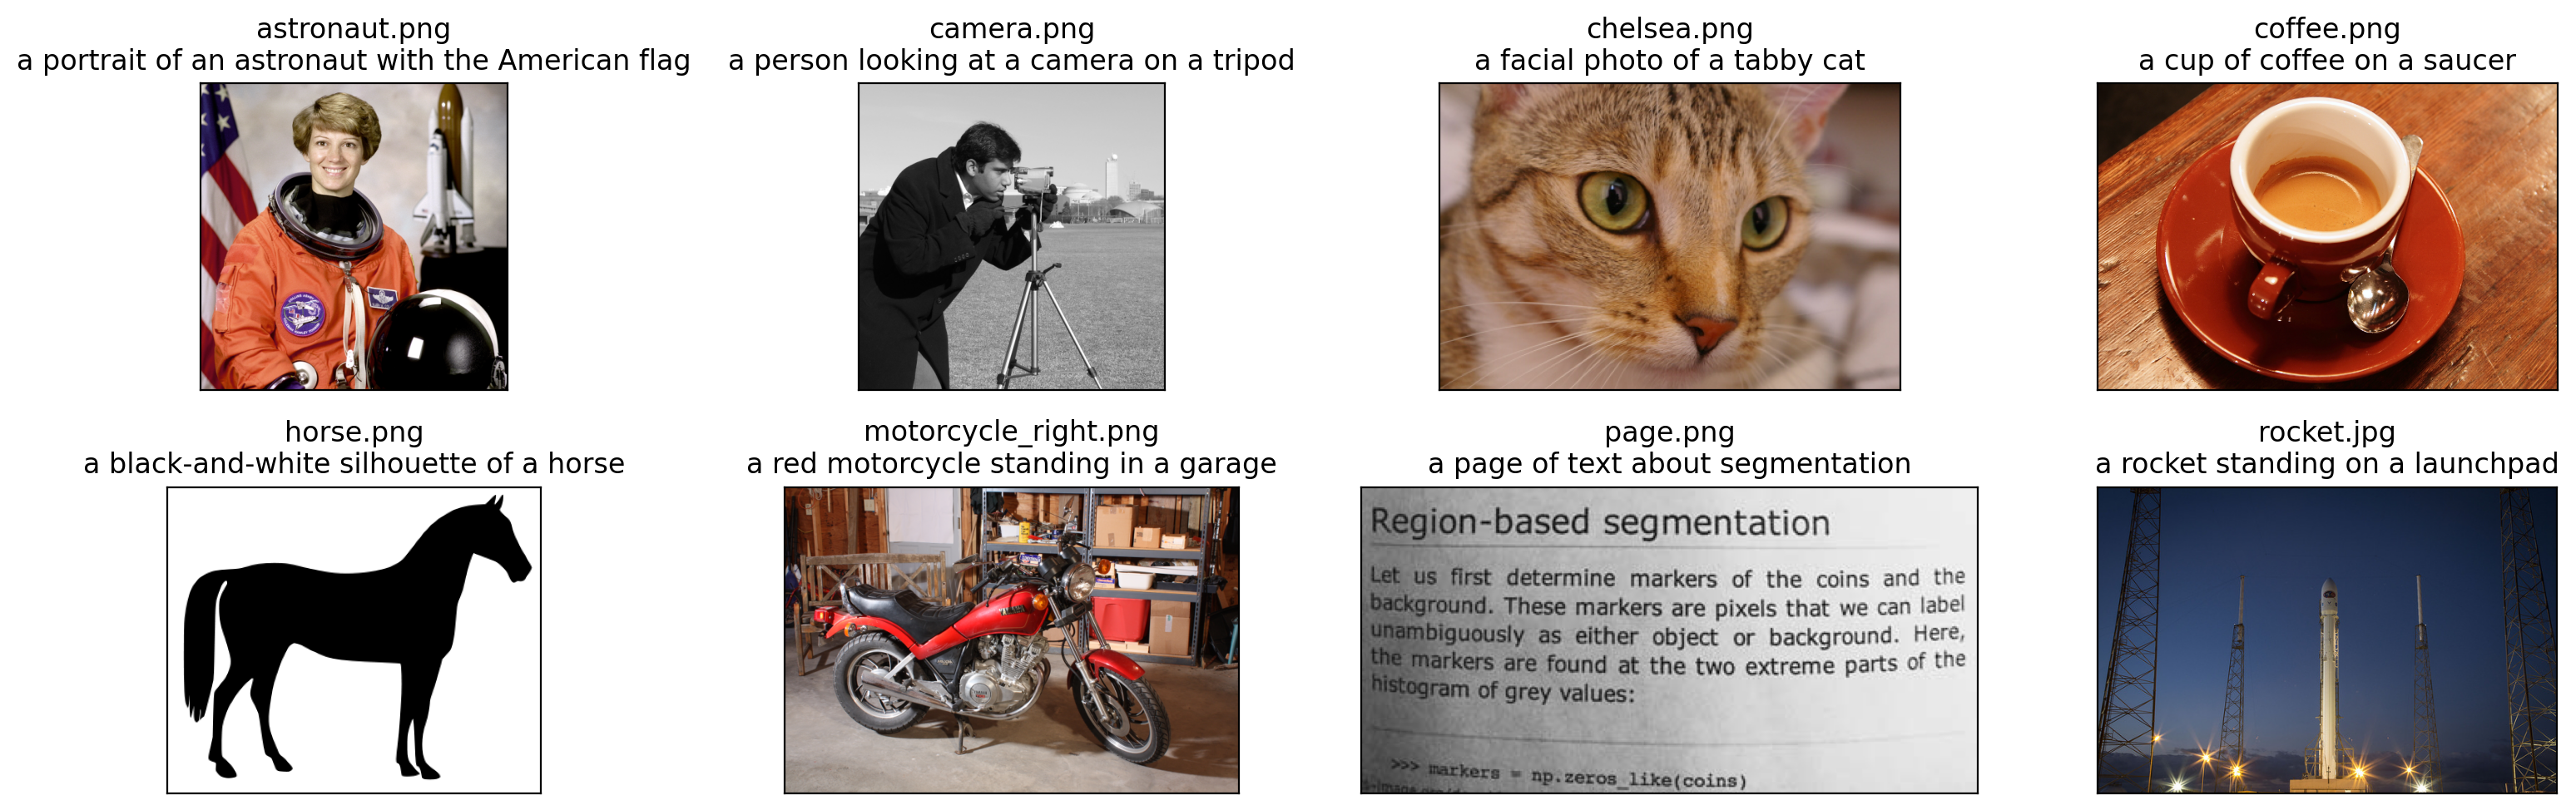

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [10]:
np.array(image).shape

(427, 640, 3)

### Video dataset example

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]

def vid_path(filename):
    return f'./data/video/train/{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def load_frame(fname, frame_type):
    path = f'./data/preproc/{frame_type}/{fname}.jpg'
    frame = cv2.imread(path)
    return frame

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

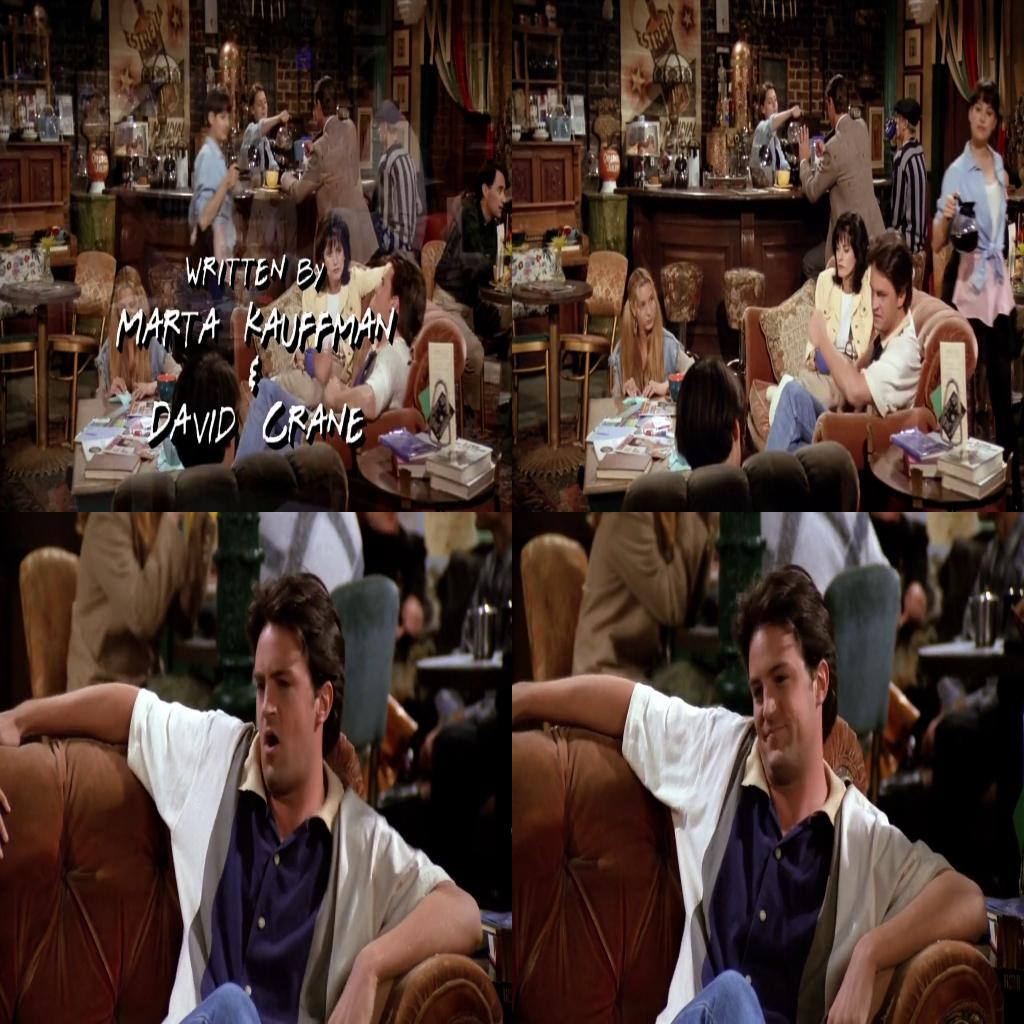

In [12]:
fname = text_data[1]['conversation'][0]['video_name'][:-4]
frame = load_frame(fname, frame_types[4])
frame_to_img(frame)

## Prepare images for encoding

In [13]:
len(text_data)

1374

In [14]:
frame_types

['frame_first', 'frame_half', 'frame_last', 'comic_3', 'comic_4']

In [17]:
import time

n_videos = len(text_data)
# frame_type = frame_types[4]
# original_images = []

batchsize = 10
batches = [list(text_data.keys())[i:i + batchsize] for i in range(0, len(text_data), batchsize)]
st = time.time()


for frame_type in frame_types:
    image_features_all = torch.empty(0, 512).cuda()
    text_features_all = torch.empty(0, 512).cuda()
    encoded_convs_utts = []

    for en_b, batch in enumerate(batches):
        images = []
        texts = []
        labels = []
        for c_i in batch:
            
            conv_dict = text_data[c_i]
            for utt_dict in conv_dict['conversation']:
                u_i = utt_dict['utterance_ID']

                fname = utt_dict['video_name'][:-4]
                frame = load_frame(fname, frame_type)
                if frame is None:
                    continue
                else:
                    encoded_convs_utts.append((c_i, u_i))

                frame = frame_to_img(frame)

                # original_images.append(frame)
                images.append(preprocess(frame))
                texts.append(utt_dict['text'][:250])
                labels.append(utt_dict['emotion'])

        if len(images) < 1:
            print("skipped empty images")
            continue

        image_input = torch.tensor(np.stack(images)).cuda()
        text_tokens = clip.tokenize(["" + desc for desc in texts]).cuda()

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            text_features = model.encode_text(text_tokens).float()

        # concatenate features to features_all
        image_features_all = torch.cat((image_features_all, image_features))
        text_features_all = torch.cat((text_features_all, text_features))

        print(f"[{np.round(time.time()-st, 2)}] [{frame_type}] finished batch {en_b}")

    torch.save(image_features_all, f'./data/features/{frame_type}/image_features.pt')
    torch.save(text_features_all, f'./data/features/{frame_type}/text_features.pt')
    torch.save(encoded_convs_utts, f'./data/features/{frame_type}/encoded_convs_utts.pt')



[0.38] [frame_first] finished batch 0
[0.7] [frame_first] finished batch 1
[1.04] [frame_first] finished batch 2
[1.35] [frame_first] finished batch 3
[1.64] [frame_first] finished batch 4
[1.99] [frame_first] finished batch 5
[2.42] [frame_first] finished batch 6
[2.72] [frame_first] finished batch 7
[2.89] [frame_first] finished batch 8
[3.2] [frame_first] finished batch 9
[3.64] [frame_first] finished batch 10
[3.92] [frame_first] finished batch 11
[4.2] [frame_first] finished batch 12
[4.45] [frame_first] finished batch 13
[4.63] [frame_first] finished batch 14
[4.92] [frame_first] finished batch 15
[5.13] [frame_first] finished batch 16
[5.47] [frame_first] finished batch 17
[5.79] [frame_first] finished batch 18
[6.05] [frame_first] finished batch 19
[6.33] [frame_first] finished batch 20
[6.6] [frame_first] finished batch 21
[6.85] [frame_first] finished batch 22
[7.09] [frame_first] finished batch 23
[7.38] [frame_first] finished batch 24
[7.69] [frame_first] finished batch 25


In [20]:
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')
encoded_convs_utts = torch.load(f'{path}/encoded_convs_utts.pt')
print(len(encoded_convs_utts))

9966


In [19]:
missing_encodings = {frame_type: [] for frame_type in frame_types}

for frame_type in frame_types:
    path = f'./data/features/{frame_type}'
    encoded_convs_utts = torch.load(f'{path}/encoded_convs_utts.pt')
    for c_id, conv in text_data.items():
        for utt in conv['conversation']:
            u_id = utt['utterance_ID']
            if (c_id, u_id) not in encoded_convs_utts:
                missing_encodings[frame_type].append((c_id, u_id))

    print(f"{frame_type} missing encodings: {len(missing_encodings[frame_type])}")

frame_first missing encodings: 3653
frame_half missing encodings: 3653
frame_last missing encodings: 3653
comic_3 missing encodings: 3653
comic_4 missing encodings: 3653


In [23]:
# compare all missing encodings if they're the same
for ft_1 in frame_types:
    for ft_2 in frame_types:
        if ft_1 == ft_2:
            continue

        if missing_encodings[ft_1] != missing_encodings[ft_2]:
            print(f"{ft_1} and {ft_2} missing encodings are NOT THE SAME")
        else:
            print(f"{ft_1} and {ft_2} missing encodings are same")

frame_first and frame_half missing encodings are same
frame_first and frame_last missing encodings are same
frame_first and comic_3 missing encodings are same
frame_first and comic_4 missing encodings are same
frame_half and frame_first missing encodings are same
frame_half and frame_last missing encodings are same
frame_half and comic_3 missing encodings are same
frame_half and comic_4 missing encodings are same
frame_last and frame_first missing encodings are same
frame_last and frame_half missing encodings are same
frame_last and comic_3 missing encodings are same
frame_last and comic_4 missing encodings are same
comic_3 and frame_first missing encodings are same
comic_3 and frame_half missing encodings are same
comic_3 and frame_last missing encodings are same
comic_3 and comic_4 missing encodings are same
comic_4 and frame_first missing encodings are same
comic_4 and frame_half missing encodings are same
comic_4 and frame_last missing encodings are same
comic_4 and comic_3 missing

9966


## Prepare encodings and labels for classification

In [25]:
text_data_filtered = text_data.copy()
for c_id, conv in text_data.items():
    text_data_filtered[c_id]['conversation'] = [utt for utt in conv['conversation'] if (c_id, utt['utterance_ID']) not in missing_encodings[frame_types[4]]]

n_utts = 0
labels = []
for c_id, conv in text_data_filtered.items():
    n_utts += len(conv['conversation'])
    labels += [utt['emotion'] for utt in conv['conversation']]

print(len(labels))

9966


In [28]:
import pandas as pd
pd.Series(labels).value_counts()

neutral     4389
joy         1708
surprise    1365
anger       1140
sadness      789
disgust      301
fear         274
Name: count, dtype: int64

In [52]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

onehot_encoder = OneHotEncoder()
Y = onehot_encoder.fit_transform(np.array(labels).reshape(-1, 1))
Y = torch.tensor(Y.toarray()).cuda()

In [53]:
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')

X = torch.cat((image_features, text_features), dim=1)
X.shape

torch.Size([9966, 1024])

In [55]:
print(torch.isnan(X).sum(), torch.isnan(Y).sum())

tensor(0, device='cuda:0') tensor(0, device='cuda:0')


## Classification